In [1]:
print("Hi")
print("LOSO with fine tuning")

Hi
LOSO with fine tuning


In [2]:
# Install required packages
import subprocess
import sys

packages = ['tensorflow', 'moabb', 'mne', 'scikit-learn', 'matplotlib', 'pyriemann', 'scipy']
for package in packages:
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', package])

print("✓ All packages installed successfully!")

✓ All packages installed successfully!


In [3]:
# Import all required libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model, clone_model
from tensorflow.keras.layers import (Dense, Activation, Dropout, Conv2D,
                                      MaxPooling2D, AveragePooling2D,
                                      SeparableConv2D, DepthwiseConv2D,
                                      BatchNormalization, SpatialDropout2D,
                                      Input, Flatten)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.constraints import max_norm

from moabb.datasets import BNCI2014001
from moabb.paradigms import MotorImagery
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import time
import copy

print("✓ All libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")

✓ All libraries imported successfully!
TensorFlow version: 2.19.0


In [4]:
# EEGNet Architecture
def EEGNet(nb_classes, Chans=64, Samples=128,
           dropoutRate=0.5, kernLength=64, F1=8,
           D=2, F2=16, norm_rate=0.25, dropoutType='Dropout'):
    """
    Keras Implementation of EEGNet

    Compact convolutional neural network for EEG classification.
    Uses depthwise separable convolutions.
    """

    if dropoutType == 'SpatialDropout2D':
        dropoutType = SpatialDropout2D
    elif dropoutType == 'Dropout':
        dropoutType = Dropout
    else:
        raise ValueError('dropoutType must be Dropout or SpatialDropout2D')

    input1 = Input(shape=(Chans, Samples, 1))

    # Block 1: Temporal + Spatial
    block1 = Conv2D(F1, (1, kernLength), padding='same',
                    input_shape=(Chans, Samples, 1),
                    use_bias=False)(input1)
    block1 = BatchNormalization()(block1)

    block1 = DepthwiseConv2D((Chans, 1), use_bias=False,
                             depth_multiplier=D,
                             depthwise_constraint=max_norm(1.))(block1)
    block1 = BatchNormalization()(block1)
    block1 = Activation('elu')(block1)
    block1 = AveragePooling2D((1, 4))(block1)
    block1 = dropoutType(dropoutRate)(block1)

    # Block 2: Separable
    block2 = SeparableConv2D(F2, (1, 16),
                             use_bias=False, padding='same')(block1)
    block2 = BatchNormalization()(block2)
    block2 = Activation('elu')(block2)
    block2 = AveragePooling2D((1, 8))(block2)
    block2 = dropoutType(dropoutRate)(block2)

    # Classifier
    flatten = Flatten(name='flatten')(block2)
    dense = Dense(nb_classes, name='dense',
                  kernel_constraint=max_norm(norm_rate))(flatten)
    softmax = Activation('softmax', name='softmax')(dense)

    model = Model(inputs=input1, outputs=softmax)

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

print("✓ EEGNet function defined successfully!")

✓ EEGNet function defined successfully!


In [5]:
# EEGNet Architecture
def EEGNet(nb_classes, Chans=64, Samples=128,
           dropoutRate=0.5, kernLength=64, F1=8,
           D=2, F2=16, norm_rate=0.25, dropoutType='Dropout'):
    """
    Keras Implementation of EEGNet

    Compact convolutional neural network for EEG classification.
    Uses depthwise separable convolutions.
    """

    if dropoutType == 'SpatialDropout2D':
        dropoutType = SpatialDropout2D
    elif dropoutType == 'Dropout':
        dropoutType = Dropout
    else:
        raise ValueError('dropoutType must be Dropout or SpatialDropout2D')

    input1 = Input(shape=(Chans, Samples, 1))

    # Block 1: Temporal + Spatial
    block1 = Conv2D(F1, (1, kernLength), padding='same',
                    input_shape=(Chans, Samples, 1),
                    use_bias=False)(input1)
    block1 = BatchNormalization()(block1)

    block1 = DepthwiseConv2D((Chans, 1), use_bias=False,
                             depth_multiplier=D,
                             depthwise_constraint=max_norm(1.))(block1)
    block1 = BatchNormalization()(block1)
    block1 = Activation('elu')(block1)
    block1 = AveragePooling2D((1, 4))(block1)
    block1 = dropoutType(dropoutRate)(block1)

    # Block 2: Separable
    block2 = SeparableConv2D(F2, (1, 16),
                             use_bias=False, padding='same')(block1)
    block2 = BatchNormalization()(block2)
    block2 = Activation('elu')(block2)
    block2 = AveragePooling2D((1, 8))(block2)
    block2 = dropoutType(dropoutRate)(block2)

    # Classifier
    flatten = Flatten(name='flatten')(block2)
    dense = Dense(nb_classes, name='dense',
                  kernel_constraint=max_norm(norm_rate))(flatten)
    softmax = Activation('softmax', name='softmax')(dense)

    model = Model(inputs=input1, outputs=softmax)

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

print("✓ EEGNet function defined successfully!")

✓ EEGNet function defined successfully!


In [6]:
# Load BCI IV 2a Dataset
print("Loading BNCI2014001 (BCI IV 2a) dataset...")
dataset = BNCI2014001()
paradigm = MotorImagery(n_classes=4)

# Get data for all subjects
X, labels, meta = paradigm.get_data(dataset=dataset, subjects=list(range(1, 10)))

print(f"\n✓ Dataset loaded successfully!")
print(f"  Total EEG data shape: {X.shape}")
print(f"  Channels: {X.shape[1]}")
print(f"  Timepoints: {X.shape[2]}")
print(f"  Total samples: {len(labels)}")
print(f"  Number of subjects: {len(np.unique(meta['subject']))}")
print(f"  Subjects: {sorted(np.unique(meta['subject']))}")

# Store for later
all_subjects = sorted(np.unique(meta['subject']))
n_subjects = len(all_subjects)

/usr/local/lib/python3.12/dist-packages/moabb/datasets/download.py:60: RuntimeWarning: Setting non-standard config type: "MNE_DATASETS_BNCI_PATH"
  set_config(key, get_config("MNE_DATA"))


Loading BNCI2014001 (BCI IV 2a) dataset...


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1064: InsecureRequestWarning: Unverified HTTPS request is being made to host 'bnci-horizon-2020.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1064: InsecureRequestWarning: Unverified HTTPS request is being made to host 'lampx.tugraz.at'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
100%|█████████████████████████████████████| 42.8M/42.8M [00:00<00:00, 18.9GB/s]
SHA256 hash of downloaded file: 054f02e70cf9c4ada1517e9b9864f45407939c1062c6793516585c6f511d0325
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
/usr/local/lib/python3.12/dist-packages/urllib3/conn


✓ Dataset loaded successfully!
  Total EEG data shape: (5184, 22, 1001)
  Channels: 22
  Timepoints: 1001
  Total samples: 5184
  Number of subjects: 9
  Subjects: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9)]


In [ ]:
# LOSO + Fine-Tuning Pipeline
print("\n" + "="*100)
print("LOSO + SUBJECT-SPECIFIC FINE-TUNING: EEGNet")
print("="*100)

# Configuration
LOSO_EPOCHS = 100
LOSO_BATCH_SIZE = 16
LOSO_EARLY_STOPPING = 15

FINETUNE_EPOCHS = 50  # Fewer epochs for fine-tuning
FINETUNE_BATCH_SIZE = 8  # Smaller batch size for small dataset
FINETUNE_EARLY_STOPPING = 10
FINETUNE_LR = 0.0001  # Lower learning rate for fine-tuning

# Results storage
results = {
    'fold': [],
    'test_subject': [],
    'loso_accuracy': [],
    'loso_loss': [],
    'finetune_samples': [],
    'finetune_accuracy': [],
    'finetune_loss': [],
    'improvement': [],
    'loso_time': [],
    'finetune_time': [],
    'loso_cm': [],
    'finetune_cm': [],
    'loso_y_true': [],
    'loso_y_pred': [],
    'finetune_y_true': [],
    'finetune_y_pred': []
}

# Enable mixed precision
try:
    from tensorflow.keras import mixed_precision
    policy = mixed_precision.Policy('mixed_float16')
    mixed_precision.set_global_policy(policy)
    print("✓ Mixed precision enabled")
except:
    print("✓ Using default precision")

print(f"\nConfiguration:")
print(f"  LOSO Training:      {LOSO_EPOCHS} epochs, batch size {LOSO_BATCH_SIZE}")
print(f"  Fine-Tuning:        {FINETUNE_EPOCHS} epochs, batch size {FINETUNE_BATCH_SIZE}")
print(f"  Fine-Tune LR:       {FINETUNE_LR}")
print(f"  Calibration Data:   40% of test subject")
print(f"  Evaluation Data:    60% of test subject")
print(f"\n" + "="*100 + "\n")

total_time_start = time.time()

# LOSO Folds with Fine-Tuning
for fold_idx, test_subject in enumerate(all_subjects, 1):
    print(f"[Fold {fold_idx}/9] Test Subject: {int(test_subject):2d}", flush=True)

    # ========== STAGE 1: LOSO TRAINING ==========
    loso_time_start = time.time()

    # Define train and test sets
    train_subjects = [s for s in all_subjects if s != test_subject]

    # Extract training data (8 subjects pooled)
    train_idx = meta['subject'].isin(train_subjects)
    X_train_all = X[train_idx]
    y_train_all = labels[train_idx]

    # Extract test data (1 subject held-out) - this will be split further for fine-tuning
    test_idx = meta['subject'] == test_subject
    X_test_subject = X[test_idx]
    y_test_subject = labels[test_idx]

    # Encode labels for training data
    le = LabelEncoder()
    y_train_encoded = le.fit_transform(y_train_all)
    y_train_onehot = to_categorical(y_train_encoded, num_classes=4)

    # Reshape for EEGNet
    X_train_reshaped = np.expand_dims(X_train_all, axis=-1)

    # Train/val split on training data
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_reshaped, y_train_onehot,
        test_size=0.2, random_state=42, stratify=y_train_encoded
    )

    # Build LOSO model
    nb_classes = 4
    Chans = X_train.shape[1]
    Samples = X_train.shape[2]

    loso_model = EEGNet(nb_classes=nb_classes, Chans=Chans, Samples=Samples,
                        dropoutRate=0.5, kernLength=64, F1=8, D=2, F2=16)

    # Early stopping for LOSO
    early_stop_loso = EarlyStopping(monitor='val_loss',
                                     patience=LOSO_EARLY_STOPPING,
                                     restore_best_weights=True,
                                     verbose=0)

    # Train LOSO model on pooled 8 subjects
    history_loso = loso_model.fit(
        X_train, y_train,
        batch_size=LOSO_BATCH_SIZE,
        epochs=LOSO_EPOCHS,
        verbose=0,
        callbacks=[early_stop_loso],
        validation_data=(X_val, y_val)
    )

    # ========== STAGE 2: LOSO EVALUATION ON FULL TEST SET ==========
    X_test_subject_reshaped = np.expand_dims(X_test_subject, axis=-1)
    y_test_subject_encoded = le.transform(y_test_subject)
    y_test_subject_onehot = to_categorical(y_test_subject_encoded, num_classes=4)

    loso_loss, loso_acc = loso_model.evaluate(X_test_subject_reshaped, y_test_subject_onehot, verbose=0)

    # LOSO predictions
    loso_y_pred_probs = loso_model.predict(X_test_subject_reshaped, verbose=0)
    loso_y_pred = np.argmax(loso_y_pred_probs, axis=1)
    loso_y_true = np.argmax(y_test_subject_onehot, axis=1)
    loso_cm = confusion_matrix(loso_y_true, loso_y_pred, labels=[0, 1, 2, 3])

    loso_time_elapsed = time.time() - loso_time_start

    print(f"  ├─ LOSO Training:   Acc={loso_acc*100:6.2f}% | Time={loso_time_elapsed:6.1f}s")

    # ========== STAGE 3: SPLIT TEST SUBJECT DATA FOR FINE-TUNING ==========
    # Split test subject's data: 40% for fine-tuning calibration, 60% for evaluation
    X_finetune_calib, X_finetune_eval, y_finetune_calib, y_finetune_eval = train_test_split(
        X_test_subject_reshaped, y_test_subject_onehot,
        test_size=0.6, random_state=42, stratify=y_test_subject_encoded
    )

    # ========== STAGE 4: FINE-TUNE MODEL ON 50% TEST SUBJECT DATA ==========
    finetune_time_start = time.time()

    # Clone LOSO model for fine-tuning
    finetune_model = clone_model(loso_model)
    finetune_model.set_weights(loso_model.get_weights())

    # Compile with lower learning rate for fine-tuning
    finetune_model.compile(
        optimizer=Adam(learning_rate=FINETUNE_LR),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Early stopping for fine-tuning
    early_stop_finetune = EarlyStopping(monitor='loss',
                                         patience=FINETUNE_EARLY_STOPPING,
                                         restore_best_weights=True,
                                         verbose=0)

    # Fine-tune on 50% calibration data (no validation split since small dataset)
    history_finetune = finetune_model.fit(
        X_finetune_calib, y_finetune_calib,
        batch_size=FINETUNE_BATCH_SIZE,
        epochs=FINETUNE_EPOCHS,
        verbose=0,
        callbacks=[early_stop_finetune]
    )

    # ========== STAGE 5: EVALUATE FINE-TUNED MODEL ON REMAINING 50% TEST DATA ==========
    finetune_loss, finetune_acc = finetune_model.evaluate(X_finetune_eval, y_finetune_eval, verbose=0)

    # Fine-tuned predictions
    finetune_y_pred_probs = finetune_model.predict(X_finetune_eval, verbose=0)
    finetune_y_pred = np.argmax(finetune_y_pred_probs, axis=1)
    finetune_y_true = np.argmax(y_finetune_eval, axis=1)
    finetune_cm = confusion_matrix(finetune_y_true, finetune_y_pred, labels=[0, 1, 2, 3])

    finetune_time_elapsed = time.time() - finetune_time_start

    # Calculate improvement
    improvement = (finetune_acc - loso_acc) * 100
    improvement_pct = (improvement / (loso_acc * 100)) * 100 if loso_acc > 0 else 0

    print(f"  └─ Fine-Tuning:     Acc={finetune_acc*100:6.2f}% | Improvement={improvement:+6.2f}pp ({improvement_pct:+6.1f}%) | Time={finetune_time_elapsed:6.1f}s")

    # Store results
    results['fold'].append(fold_idx)
    results['test_subject'].append(test_subject)
    results['loso_accuracy'].append(loso_acc)
    results['loso_loss'].append(loso_loss)
    results['finetune_samples'].append(len(X_finetune_calib))
    results['finetune_accuracy'].append(finetune_acc)
    results['finetune_loss'].append(finetune_loss)
    results['improvement'].append(improvement * 100)  # Convert to percentage points
    results['loso_time'].append(loso_time_elapsed)
    results['finetune_time'].append(finetune_time_elapsed)
    results['loso_cm'].append(loso_cm)
    results['finetune_cm'].append(finetune_cm)
    results['loso_y_true'].append(loso_y_true)
    results['loso_y_pred'].append(loso_y_pred)
    results['finetune_y_true'].append(finetune_y_true)
    results['finetune_y_pred'].append(finetune_y_pred)

    # Cleanup
    del loso_model, finetune_model, history_loso, history_finetune
    tf.keras.backend.clear_session()

    print()

total_time_elapsed = time.time() - total_time_start

print("\n" + "="*100)
print(f"✓ LOSO + Fine-Tuning Complete!")
print(f"  Total Time: {total_time_elapsed:.1f}s ({total_time_elapsed/60:.1f} min)")
print(f"="*100)


LOSO + SUBJECT-SPECIFIC FINE-TUNING: EEGNet
✓ Mixed precision enabled

Configuration:
  LOSO Training:      100 epochs, batch size 16
  Fine-Tuning:        50 epochs, batch size 8
  Fine-Tune LR:       0.0001
  Calibration Data:   50% of test subject
  Evaluation Data:    50% of test subject


[Fold 1/9] Test Subject:  1


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  ├─ LOSO Training:   Acc= 58.68% | Time=  92.6s
  └─ Fine-Tuning:     Acc= 74.31% | Improvement=+15.62pp ( +26.6%) | Time=  19.1s

[Fold 2/9] Test Subject:  2


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  ├─ LOSO Training:   Acc= 28.12% | Time= 162.9s
  └─ Fine-Tuning:     Acc= 39.58% | Improvement=+11.46pp ( +40.7%) | Time=  17.1s

[Fold 3/9] Test Subject:  3


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  ├─ LOSO Training:   Acc= 59.20% | Time= 170.6s
  └─ Fine-Tuning:     Acc= 88.89% | Improvement=+29.69pp ( +50.1%) | Time=  16.9s

[Fold 4/9] Test Subject:  4


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  ├─ LOSO Training:   Acc= 34.90% | Time= 156.4s
  └─ Fine-Tuning:     Acc= 52.43% | Improvement=+17.53pp ( +50.2%) | Time=  16.3s

[Fold 5/9] Test Subject:  5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  ├─ LOSO Training:   Acc= 27.60% | Time= 158.6s
  └─ Fine-Tuning:     Acc= 32.99% | Improvement= +5.38pp ( +19.5%) | Time=  15.4s

[Fold 6/9] Test Subject:  6


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  ├─ LOSO Training:   Acc= 28.12% | Time= 169.5s
  └─ Fine-Tuning:     Acc= 52.43% | Improvement=+24.31pp ( +86.4%) | Time=  16.3s

[Fold 7/9] Test Subject:  7


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  ├─ LOSO Training:   Acc= 33.33% | Time= 175.4s
  └─ Fine-Tuning:     Acc= 60.42% | Improvement=+27.08pp ( +81.3%) | Time=  16.3s

[Fold 8/9] Test Subject:  8


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  ├─ LOSO Training:   Acc= 64.41% | Time= 180.5s
  └─ Fine-Tuning:     Acc= 79.86% | Improvement=+15.45pp ( +24.0%) | Time=  13.1s

[Fold 9/9] Test Subject:  9


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  ├─ LOSO Training:   Acc= 62.85% | Time= 168.4s
  └─ Fine-Tuning:     Acc= 82.99% | Improvement=+20.14pp ( +32.0%) | Time=  15.0s


✓ LOSO + Fine-Tuning Complete!
  Total Time: 1584.3s (26.4 min)


In [7]:
import time
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import clone_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

# (Assuming EEGNet, X, labels, meta, all_subjects are defined above)

print("\n" + "="*100)
print("LOSO + SUBJECT-SPECIFIC FINE-TUNING (Multiple Splits): EEGNet")
print("="*100)

# Configuration
LOSO_EPOCHS = 100
LOSO_BATCH_SIZE = 16
LOSO_EARLY_STOPPING = 15

FINETUNE_EPOCHS = 50
FINETUNE_BATCH_SIZE = 8
FINETUNE_EARLY_STOPPING = 10
FINETUNE_LR = 0.0001

# <--- NEW: Define the splits you want to test
FINETUNE_TEST_SPLITS = [0.3, 0.4, 0.5,0.6 , 0.7]

# Results storage
results = {
    'fold': [],
    'test_subject': [],
    'loso_accuracy': [],
    'loso_loss': [],
    'finetune_test_split': [], # <--- NEW: To store which split was used
    'finetune_samples': [],
    'finetune_accuracy': [],
    'finetune_loss': [],
    'improvement': [],
    'loso_time': [],
    'finetune_time': [],
    'loso_cm': [],
    'finetune_cm': [],
    'loso_y_true': [],
    'loso_y_pred': [],
    'finetune_y_true': [],
    'finetune_y_pred': []
}

# Enable mixed precision
try:
    from tensorflow.keras import mixed_precision
    policy = mixed_precision.Policy('mixed_float16')
    mixed_precision.set_global_policy(policy)
    print("✓ Mixed precision enabled")
except:
    print("✓ Using default precision")

print(f"\nConfiguration:")
print(f"  LOSO Training:      {LOSO_EPOCHS} epochs, batch size {LOSO_BATCH_SIZE}")
print(f"  Fine-Tuning:        {FINETUNE_EPOCHS} epochs, batch size {FINETUNE_BATCH_SIZE}")
print(f"  Fine-Tune LR:       {FINETUNE_LR}")
# <--- MODIFIED: Updated print statements
print(f"  Test Splits (Eval): {FINETUNE_TEST_SPLITS}")
print(f"  (Calibration splits will be 0.7, 0.6, 0.5 respectively)")
print(f"\n" + "="*100 + "\n")

total_time_start = time.time()

# LOSO Folds with Fine-Tuning
for fold_idx, test_subject in enumerate(all_subjects, 1):
    print(f"[Fold {fold_idx}/9] Test Subject: {int(test_subject):2d}", flush=True)

    # ========== STAGE 1: LOSO TRAINING ==========
    loso_time_start = time.time()

    train_subjects = [s for s in all_subjects if s != test_subject]
    train_idx = meta['subject'].isin(train_subjects)
    X_train_all = X[train_idx]
    y_train_all = labels[train_idx]

    test_idx = meta['subject'] == test_subject
    X_test_subject = X[test_idx]
    y_test_subject = labels[test_idx]

    le = LabelEncoder()
    y_train_encoded = le.fit_transform(y_train_all)
    y_train_onehot = to_categorical(y_train_encoded, num_classes=4)

    X_train_reshaped = np.expand_dims(X_train_all, axis=-1)

    X_train, X_val, y_train, y_val = train_test_split(
        X_train_reshaped, y_train_onehot,
        test_size=0.2, random_state=42, stratify=y_train_encoded
    )

    nb_classes = 4
    Chans = X_train.shape[1]
    Samples = X_train.shape[2]

    loso_model = EEGNet(nb_classes=nb_classes, Chans=Chans, Samples=Samples,
                        dropoutRate=0.5, kernLength=64, F1=8, D=2, F2=16)

    early_stop_loso = EarlyStopping(monitor='val_loss',
                                     patience=LOSO_EARLY_STOPPING,
                                     restore_best_weights=True,
                                     verbose=0)

    history_loso = loso_model.fit(
        X_train, y_train,
        batch_size=LOSO_BATCH_SIZE,
        epochs=LOSO_EPOCHS,
        verbose=0,
        callbacks=[early_stop_loso],
        validation_data=(X_val, y_val)
    )

    # ========== STAGE 2: LOSO EVALUATION ON FULL TEST SET ==========
    X_test_subject_reshaped = np.expand_dims(X_test_subject, axis=-1)
    y_test_subject_encoded = le.transform(y_test_subject)
    y_test_subject_onehot = to_categorical(y_test_subject_encoded, num_classes=4)

    loso_loss, loso_acc = loso_model.evaluate(X_test_subject_reshaped, y_test_subject_onehot, verbose=0)

    loso_y_pred_probs = loso_model.predict(X_test_subject_reshaped, verbose=0)
    loso_y_pred = np.argmax(loso_y_pred_probs, axis=1)
    loso_y_true = np.argmax(y_test_subject_onehot, axis=1)
    loso_cm = confusion_matrix(loso_y_true, loso_y_pred, labels=[0, 1, 2, 3])

    loso_time_elapsed = time.time() - loso_time_start

    print(f"  ├─ LOSO Training:   Acc={loso_acc*100:6.2f}% | Time={loso_time_elapsed:6.1f}s")

    # <--- NEW: Inner loop to iterate over test splits ---
    for eval_test_size in FINETUNE_TEST_SPLITS:

        calib_percent = (1 - eval_test_size) * 100
        print(f"  ├─ Testing Split:   {calib_percent:.0f}% Calib / {eval_test_size*100:.0f}% Eval (test_size={eval_test_size})")

        # ========== STAGE 3: SPLIT TEST SUBJECT DATA FOR FINE-TUNING ==========
        # <--- All code from here is indented inside the new loop ---
        X_finetune_calib, X_finetune_eval, y_finetune_calib, y_finetune_eval = train_test_split(
            X_test_subject_reshaped, y_test_subject_onehot,
            test_size=eval_test_size,  # <--- MODIFIED: Use loop variable
            random_state=42, stratify=y_test_subject_encoded
        )

        # ========== STAGE 4: FINE-TUNE MODEL ON CALIBRATION DATA ==========
        finetune_time_start = time.time()

        # Clone LOSO model for fine-tuning
        # This is done *inside* the loop to get a fresh model each time
        finetune_model = clone_model(loso_model)
        finetune_model.set_weights(loso_model.get_weights())

        finetune_model.compile(
            optimizer=Adam(learning_rate=FINETUNE_LR),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

        early_stop_finetune = EarlyStopping(monitor='loss',
                                             patience=FINETUNE_EARLY_STOPPING,
                                             restore_best_weights=True,
                                             verbose=0)

        history_finetune = finetune_model.fit(
            X_finetune_calib, y_finetune_calib,
            batch_size=FINETUNE_BATCH_SIZE,
            epochs=FINETUNE_EPOCHS,
            verbose=0,
            callbacks=[early_stop_finetune]
        )

        # ========== STAGE 5: EVALUATE FINE-TUNED MODEL ON EVALUATION DATA ==========
        finetune_loss, finetune_acc = finetune_model.evaluate(X_finetune_eval, y_finetune_eval, verbose=0)

        finetune_y_pred_probs = finetune_model.predict(X_finetune_eval, verbose=0)
        finetune_y_pred = np.argmax(finetune_y_pred_probs, axis=1)
        finetune_y_true = np.argmax(y_finetune_eval, axis=1)
        finetune_cm = confusion_matrix(finetune_y_true, finetune_y_pred, labels=[0, 1, 2, 3])

        finetune_time_elapsed = time.time() - finetune_time_start

        # Calculate improvement
        improvement = (finetune_acc - loso_acc) * 100
        improvement_pct = (improvement / (loso_acc * 100)) * 100 if loso_acc > 0 else 0

        # <--- MODIFIED: Changed print prefix for clarity
        print(f"  │  └─ Fine-Tuning:   Acc={finetune_acc*100:6.2f}% | Improvement={improvement:+6.2f}pp ({improvement_pct:+6.1f}%) | Time={finetune_time_elapsed:6.1f}s")

        # Store results
        # This will now append results for each split
        results['fold'].append(fold_idx)
        results['test_subject'].append(test_subject)
        results['loso_accuracy'].append(loso_acc) # LOSO results are repeated for easy comparison
        results['loso_loss'].append(loso_loss)
        results['finetune_test_split'].append(eval_test_size) # <--- NEW: Store the split size
        results['finetune_samples'].append(len(X_finetune_calib))
        results['finetune_accuracy'].append(finetune_acc)
        results['finetune_loss'].append(finetune_loss)
        results['improvement'].append(improvement * 100)
        results['loso_time'].append(loso_time_elapsed)
        results['finetune_time'].append(finetune_time_elapsed)
        results['loso_cm'].append(loso_cm)
        results['finetune_cm'].append(finetune_cm)
        results['loso_y_true'].append(loso_y_true)
        results['loso_y_pred'].append(loso_y_pred)
        results['finetune_y_true'].append(finetune_y_true)
        results['finetune_y_pred'].append(finetune_y_pred)

        # Cleanup for inner loop
        del finetune_model, history_finetune
        tf.keras.backend.clear_session()

    # <--- End of new inner loop

    # Cleanup for outer loop
    del loso_model, history_loso
    print() # Add a newline between folds

total_time_elapsed = time.time() - total_time_start

print("\n" + "="*100)
print(f"✓ LOSO + Fine-Tuning (Multiple Splits) Complete!")
print(f"  Total Time: {total_time_elapsed:.1f}s ({total_time_elapsed/60:.1f} min)")
print(f"  Total results generated: {len(results['fold'])}")
print(f"="*100)

# You can now easily convert this to a pandas DataFrame to analyze the splits
# import pandas as pd
# df = pd.DataFrame(results)
# print(df.groupby('finetune_test_split')[['loso_accuracy', 'finetune_accuracy', 'improvement']].mean())


LOSO + SUBJECT-SPECIFIC FINE-TUNING (Multiple Splits): EEGNet
✓ Mixed precision enabled

Configuration:
  LOSO Training:      100 epochs, batch size 16
  Fine-Tuning:        50 epochs, batch size 8
  Fine-Tune LR:       0.0001
  Test Splits (Eval): [0.3, 0.4, 0.5, 0.6, 0.7]
  (Calibration splits will be 0.7, 0.6, 0.5 respectively)


[Fold 1/9] Test Subject:  1


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  ├─ LOSO Training:   Acc= 58.85% | Time= 164.8s
  ├─ Testing Split:   70% Calib / 30% Eval (test_size=0.3)
  │  └─ Fine-Tuning:   Acc= 85.55% | Improvement=+26.69pp ( +45.4%) | Time=  29.6s
  ├─ Testing Split:   60% Calib / 40% Eval (test_size=0.4)
  │  └─ Fine-Tuning:   Acc= 82.25% | Improvement=+23.40pp ( +39.8%) | Time=  27.0s
  ├─ Testing Split:   50% Calib / 50% Eval (test_size=0.5)


  │  └─ Fine-Tuning:   Acc= 81.25% | Improvement=+22.40pp ( +38.1%) | Time=  16.9s
  ├─ Testing Split:   40% Calib / 60% Eval (test_size=0.6)
  │  └─ Fine-Tuning:   Acc= 79.77% | Improvement=+20.91pp ( +35.5%) | Time=  22.6s
  ├─ Testing Split:   30% Calib / 70% Eval (test_size=0.7)
  │  └─ Fine-Tuning:   Acc= 78.96% | Improvement=+20.11pp ( +34.2%) | Time=  21.0s

[Fold 2/9] Test Subject:  2


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  ├─ LOSO Training:   Acc= 28.65% | Time= 175.7s
  ├─ Testing Split:   70% Calib / 30% Eval (test_size=0.3)
  │  └─ Fine-Tuning:   Acc= 45.09% | Improvement=+16.44pp ( +57.4%) | Time=  26.8s
  ├─ Testing Split:   60% Calib / 40% Eval (test_size=0.4)
  │  └─ Fine-Tuning:   Acc= 42.86% | Improvement=+14.21pp ( +49.6%) | Time=  25.0s
  ├─ Testing Split:   50% Calib / 50% Eval (test_size=0.5)


  │  └─ Fine-Tuning:   Acc= 39.58% | Improvement=+10.94pp ( +38.2%) | Time=  17.6s
  ├─ Testing Split:   40% Calib / 60% Eval (test_size=0.6)
  │  └─ Fine-Tuning:   Acc= 39.88% | Improvement=+11.24pp ( +39.2%) | Time=  21.0s
  ├─ Testing Split:   30% Calib / 70% Eval (test_size=0.7)
  │  └─ Fine-Tuning:   Acc= 37.87% | Improvement= +9.23pp ( +32.2%) | Time=  21.2s

[Fold 3/9] Test Subject:  3


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  ├─ LOSO Training:   Acc= 75.69% | Time= 134.9s
  ├─ Testing Split:   70% Calib / 30% Eval (test_size=0.3)
  │  └─ Fine-Tuning:   Acc= 90.17% | Improvement=+14.48pp ( +19.1%) | Time=  25.2s
  ├─ Testing Split:   60% Calib / 40% Eval (test_size=0.4)
  │  └─ Fine-Tuning:   Acc= 86.58% | Improvement=+10.89pp ( +14.4%) | Time=  17.5s
  ├─ Testing Split:   50% Calib / 50% Eval (test_size=0.5)
  │  └─ Fine-Tuning:   Acc= 89.24% | Improvement=+13.54pp ( +17.9%) | Time=  14.7s
  ├─ Testing Split:   40% Calib / 60% Eval (test_size=0.6)
  │  └─ Fine-Tuning:   Acc= 87.57% | Improvement=+11.88pp ( +15.7%) | Time=  20.8s
  ├─ Testing Split:   30% Calib / 70% Eval (test_size=0.7)
  │  └─ Fine-Tuning:   Acc= 88.37% | Improvement=+12.67pp ( +16.7%) | Time=  20.0s

[Fold 4/9] Test Subject:  4


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  ├─ LOSO Training:   Acc= 38.37% | Time= 154.8s
  ├─ Testing Split:   70% Calib / 30% Eval (test_size=0.3)
  │  └─ Fine-Tuning:   Acc= 55.49% | Improvement=+17.12pp ( +44.6%) | Time=  24.5s
  ├─ Testing Split:   60% Calib / 40% Eval (test_size=0.4)
  │  └─ Fine-Tuning:   Acc= 54.55% | Improvement=+16.18pp ( +42.2%) | Time=  23.3s
  ├─ Testing Split:   50% Calib / 50% Eval (test_size=0.5)
  │  └─ Fine-Tuning:   Acc= 59.03% | Improvement=+20.66pp ( +53.8%) | Time=  16.5s
  ├─ Testing Split:   40% Calib / 60% Eval (test_size=0.6)
  │  └─ Fine-Tuning:   Acc= 56.36% | Improvement=+17.99pp ( +46.9%) | Time=  21.4s
  ├─ Testing Split:   30% Calib / 70% Eval (test_size=0.7)
  │  └─ Fine-Tuning:   Acc= 56.19% | Improvement=+17.82pp ( +46.4%) | Time=  20.0s

[Fold 5/9] Test Subject:  5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  ├─ LOSO Training:   Acc= 27.95% | Time= 129.6s
  ├─ Testing Split:   70% Calib / 30% Eval (test_size=0.3)
  │  └─ Fine-Tuning:   Acc= 38.73% | Improvement=+10.78pp ( +38.6%) | Time=  24.7s
  ├─ Testing Split:   60% Calib / 40% Eval (test_size=0.4)
  │  └─ Fine-Tuning:   Acc= 36.80% | Improvement= +8.85pp ( +31.6%) | Time=  25.0s
  ├─ Testing Split:   50% Calib / 50% Eval (test_size=0.5)
  │  └─ Fine-Tuning:   Acc= 38.89% | Improvement=+10.94pp ( +39.1%) | Time=  16.7s
  ├─ Testing Split:   40% Calib / 60% Eval (test_size=0.6)
  │  └─ Fine-Tuning:   Acc= 34.10% | Improvement= +6.15pp ( +22.0%) | Time=  21.1s
  ├─ Testing Split:   30% Calib / 70% Eval (test_size=0.7)
  │  └─ Fine-Tuning:   Acc= 38.37% | Improvement=+10.41pp ( +37.3%) | Time=  20.2s

[Fold 6/9] Test Subject:  6


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  ├─ LOSO Training:   Acc= 27.43% | Time= 175.5s
  ├─ Testing Split:   70% Calib / 30% Eval (test_size=0.3)
  │  └─ Fine-Tuning:   Acc= 50.87% | Improvement=+23.44pp ( +85.4%) | Time=  25.2s
  ├─ Testing Split:   60% Calib / 40% Eval (test_size=0.4)
  │  └─ Fine-Tuning:   Acc= 51.95% | Improvement=+24.52pp ( +89.4%) | Time=  26.5s
  ├─ Testing Split:   50% Calib / 50% Eval (test_size=0.5)
  │  └─ Fine-Tuning:   Acc= 47.92% | Improvement=+20.49pp ( +74.7%) | Time=  18.4s
  ├─ Testing Split:   40% Calib / 60% Eval (test_size=0.6)
  │  └─ Fine-Tuning:   Acc= 52.31% | Improvement=+24.88pp ( +90.7%) | Time=  20.4s
  ├─ Testing Split:   30% Calib / 70% Eval (test_size=0.7)
  │  └─ Fine-Tuning:   Acc= 48.27% | Improvement=+20.84pp ( +76.0%) | Time=  19.6s

[Fold 7/9] Test Subject:  7


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  ├─ LOSO Training:   Acc= 35.24% | Time= 178.9s
  ├─ Testing Split:   70% Calib / 30% Eval (test_size=0.3)
  │  └─ Fine-Tuning:   Acc= 62.43% | Improvement=+27.18pp ( +77.1%) | Time=  24.8s
  ├─ Testing Split:   60% Calib / 40% Eval (test_size=0.4)
  │  └─ Fine-Tuning:   Acc= 60.17% | Improvement=+24.93pp ( +70.7%) | Time=  23.6s
  ├─ Testing Split:   50% Calib / 50% Eval (test_size=0.5)
  │  └─ Fine-Tuning:   Acc= 57.99% | Improvement=+22.74pp ( +64.5%) | Time=  17.2s
  ├─ Testing Split:   40% Calib / 60% Eval (test_size=0.6)
  │  └─ Fine-Tuning:   Acc= 57.80% | Improvement=+22.56pp ( +64.0%) | Time=  21.3s
  ├─ Testing Split:   30% Calib / 70% Eval (test_size=0.7)
  │  └─ Fine-Tuning:   Acc= 56.68% | Improvement=+21.44pp ( +60.8%) | Time=  19.4s

[Fold 8/9] Test Subject:  8


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  ├─ LOSO Training:   Acc= 71.18% | Time= 174.9s
  ├─ Testing Split:   70% Calib / 30% Eval (test_size=0.3)
  │  └─ Fine-Tuning:   Acc= 80.92% | Improvement= +9.74pp ( +13.7%) | Time=  24.8s
  ├─ Testing Split:   60% Calib / 40% Eval (test_size=0.4)
  │  └─ Fine-Tuning:   Acc= 79.22% | Improvement= +8.04pp ( +11.3%) | Time=  24.1s
  ├─ Testing Split:   50% Calib / 50% Eval (test_size=0.5)
  │  └─ Fine-Tuning:   Acc= 81.60% | Improvement=+10.42pp ( +14.6%) | Time=  18.1s
  ├─ Testing Split:   40% Calib / 60% Eval (test_size=0.6)
  │  └─ Fine-Tuning:   Acc= 79.48% | Improvement= +8.30pp ( +11.7%) | Time=  20.8s
  ├─ Testing Split:   30% Calib / 70% Eval (test_size=0.7)
  │  └─ Fine-Tuning:   Acc= 77.97% | Improvement= +6.79pp (  +9.5%) | Time=  19.6s

[Fold 9/9] Test Subject:  9


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  ├─ LOSO Training:   Acc= 61.11% | Time= 178.3s
  ├─ Testing Split:   70% Calib / 30% Eval (test_size=0.3)
  │  └─ Fine-Tuning:   Acc= 82.08% | Improvement=+20.97pp ( +34.3%) | Time=  22.0s
  ├─ Testing Split:   60% Calib / 40% Eval (test_size=0.4)
  │  └─ Fine-Tuning:   Acc= 80.52% | Improvement=+19.41pp ( +31.8%) | Time=  22.7s
  ├─ Testing Split:   50% Calib / 50% Eval (test_size=0.5)
  │  └─ Fine-Tuning:   Acc= 81.60% | Improvement=+20.49pp ( +33.5%) | Time=  16.7s
  ├─ Testing Split:   40% Calib / 60% Eval (test_size=0.6)
  │  └─ Fine-Tuning:   Acc= 81.79% | Improvement=+20.68pp ( +33.8%) | Time=  20.2s
  ├─ Testing Split:   30% Calib / 70% Eval (test_size=0.7)
  │  └─ Fine-Tuning:   Acc= 82.43% | Improvement=+21.31pp ( +34.9%) | Time=  20.2s


✓ LOSO + Fine-Tuning (Multiple Splits) Complete!
  Total Time: 2462.3s (41.0 min)
  Total results generated: 45


In [8]:
# Results Summary
print("\n" + "="*120)
print("LOSO vs LOSO + FINE-TUNING: RESULTS COMPARISON")
print("="*120)

df_results = pd.DataFrame({
    'Fold': results['fold'],
    'Test Subj': [int(s) for s in results['test_subject']],
    'LOSO Acc': [f"{acc*100:.2f}%" for acc in results['loso_accuracy']],
    'Fine-Tune Acc': [f"{acc*100:.2f}%" for acc in results['finetune_accuracy']],
    'Improvement': [f"{imp:+.2f}pp" for imp in results['improvement']],
    'Calib Samples': results['finetune_samples'],
    'Time (s)': [f"{t:.1f}" for t in [loso_t + ft_t for loso_t, ft_t in zip(results['loso_time'], results['finetune_time'])]]
})

print("\n" + df_results.to_string(index=False))

# Summary statistics
loso_accs = np.array(results['loso_accuracy']) * 100
finetune_accs = np.array(results['finetune_accuracy']) * 100
improvements = np.array(results['improvement'])

mean_loso = np.mean(loso_accs)
std_loso = np.std(loso_accs)
mean_finetune = np.mean(finetune_accs)
std_finetune = np.std(finetune_accs)
mean_improvement = np.mean(improvements)

print(f"\n{'─'*120}")
print(f"AGGREGATE STATISTICS (across 9 subjects):")
print(f"\n  LOSO Only:")
print(f"    Mean Accuracy:              {mean_loso:6.2f}% ± {std_loso:5.2f}%")
print(f"    Range:                      {min(loso_accs):6.2f}% - {max(loso_accs):6.2f}%")

print(f"\n  LOSO + Fine-Tuning (50% data):")
print(f"    Mean Accuracy:              {mean_finetune:6.2f}% ± {std_finetune:5.2f}%")
print(f"    Range:                      {min(finetune_accs):6.2f}% - {max(finetune_accs):6.2f}%")

print(f"\n  Improvement (Fine-Tuning vs LOSO):")
print(f"    Mean Improvement:           {mean_improvement:+6.2f} percentage points")
print(f"    Range:                      {min(improvements):+6.2f}pp to {max(improvements):+6.2f}pp")
print(f"    Subjects Improved:          {np.sum(improvements > 0)}/9")

print(f"\n{'─'*120}")
print(f"Per-Subject Breakdown:")
print(f"\n  {'Subj':>5} {'LOSO':>8} {'F-Tune':>8} {'Improve':>10} {'Calib Data':>12}")
print(f"  {'─'*50}")

for i in range(len(results['fold'])):
    subj = int(results['test_subject'][i])
    loso = results['loso_accuracy'][i] * 100
    ftune = results['finetune_accuracy'][i] * 100
    imp = results['improvement'][i]
    calib = results['finetune_samples'][i]
    print(f"  {subj:>5} {loso:>7.2f}% {ftune:>7.2f}% {imp:>+9.2f}pp {calib:>12} trials")

print(f"\n{'='*120}")


LOSO vs LOSO + FINE-TUNING: RESULTS COMPARISON

 Fold  Test Subj LOSO Acc Fine-Tune Acc Improvement  Calib Samples Time (s)
    1          1   58.85%        85.55%  +2669.50pp            403    194.4
    1          1   58.85%        82.25%  +2339.69pp            345    191.8
    1          1   58.85%        81.25%  +2239.58pp            288    181.7
    1          1   58.85%        79.77%  +2091.46pp            230    187.4
    1          1   58.85%        78.96%  +2010.62pp            172    185.8
    2          2   28.65%        45.09%  +1644.09pp            403    202.6
    2          2   28.65%        42.86%  +1421.13pp            345    200.7
    2          2   28.65%        39.58%  +1093.75pp            288    193.4
    2          2   28.65%        39.88%  +1123.86pp            230    196.8
    2          2   28.65%        37.87%   +922.55pp            172    196.9
    3          3   75.69%        90.17%  +1447.90pp            403    160.1
    3          3   75.69%        86.58%

/tmp/ipython-input-802908375.py:57: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax3.boxplot([loso_accs_plot, finetune_accs_plot],


TypeError: '>' not supported between instances of 'list' and 'int'

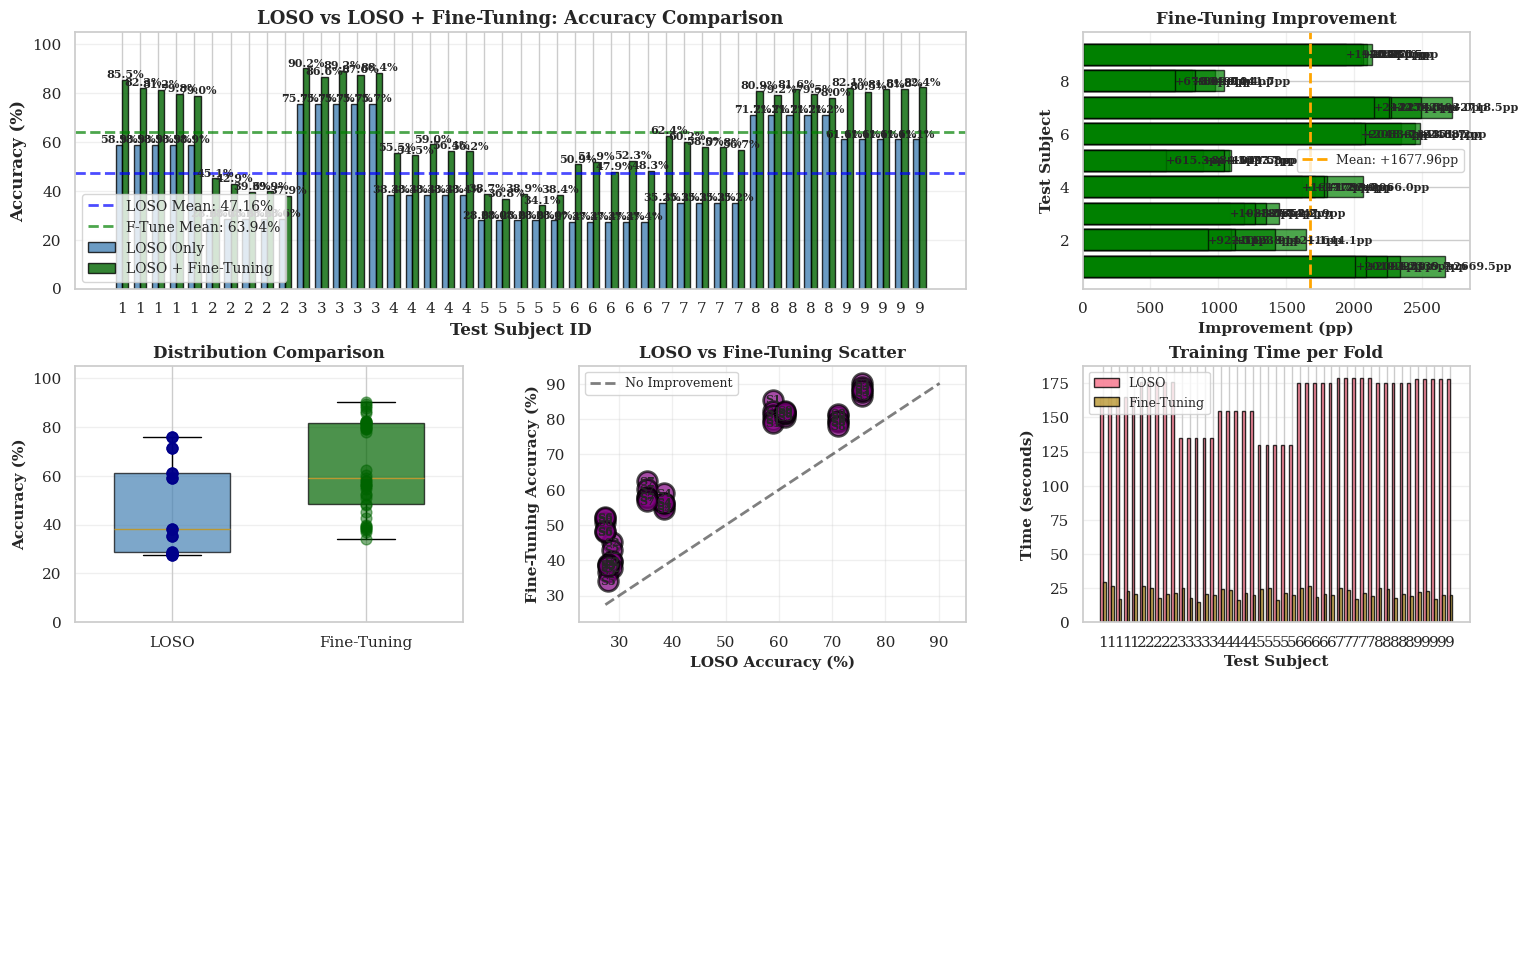

In [9]:
# Comprehensive visualization
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

test_subjects_plot = [int(s) for s in results['test_subject']]
loso_accs_plot = [acc*100 for acc in results['loso_accuracy']]
finetune_accs_plot = [acc*100 for acc in results['finetune_accuracy']]
improvements_plot = results['improvement']

# 1. LOSO vs Fine-Tuning Accuracy Comparison (Bar Chart)
ax1 = fig.add_subplot(gs[0, :2])
x_pos = np.arange(len(test_subjects_plot))
width = 0.35

bars1 = ax1.bar(x_pos - width/2, loso_accs_plot, width, label='LOSO Only',
               color='steelblue', alpha=0.8, edgecolor='black')
bars2 = ax1.bar(x_pos + width/2, finetune_accs_plot, width, label='LOSO + Fine-Tuning',
               color='darkgreen', alpha=0.8, edgecolor='black')

ax1.axhline(y=mean_loso, color='blue', linestyle='--', linewidth=2, alpha=0.7, label=f'LOSO Mean: {mean_loso:.2f}%')
ax1.axhline(y=mean_finetune, color='green', linestyle='--', linewidth=2, alpha=0.7, label=f'F-Tune Mean: {mean_finetune:.2f}%')

ax1.set_xlabel('Test Subject ID', fontsize=12, fontweight='bold')
ax1.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
ax1.set_title('LOSO vs LOSO + Fine-Tuning: Accuracy Comparison', fontsize=13, fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(test_subjects_plot)
ax1.set_ylim([0, 105])
ax1.legend(loc='lower left', fontsize=10)
ax1.grid(axis='y', alpha=0.3)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%', ha='center', va='bottom', fontsize=8, fontweight='bold')

# 2. Improvement per Subject
ax2 = fig.add_subplot(gs[0, 2])
colors_imp = ['green' if imp > 0 else 'red' for imp in improvements_plot]
bars_imp = ax2.barh(test_subjects_plot, improvements_plot, color=colors_imp, alpha=0.7, edgecolor='black')
ax2.axvline(x=mean_improvement, color='orange', linestyle='--', linewidth=2, label=f'Mean: {mean_improvement:+.2f}pp')
ax2.set_xlabel('Improvement (pp)', fontsize=11, fontweight='bold')
ax2.set_ylabel('Test Subject', fontsize=11, fontweight='bold')
ax2.set_title('Fine-Tuning Improvement', fontsize=12, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)
ax2.legend(fontsize=9)

# Add value labels
for i, (bar, imp) in enumerate(zip(bars_imp, improvements_plot)):
    ax2.text(imp, bar.get_y() + bar.get_height()/2.,
            f'{imp:+.1f}pp', ha='left' if imp > 0 else 'right', va='center', fontsize=8, fontweight='bold')

# 3. Distribution box plots
ax3 = fig.add_subplot(gs[1, 0])
bp = ax3.boxplot([loso_accs_plot, finetune_accs_plot],
                  labels=['LOSO', 'Fine-Tuning'],
                  patch_artist=True, widths=0.6)
bp['boxes'][0].set_facecolor('steelblue')
bp['boxes'][1].set_facecolor('darkgreen')
for box in bp['boxes']:
    box.set_alpha(0.7)

ax3.scatter([1]*len(loso_accs_plot), loso_accs_plot, alpha=0.5, s=60, color='darkblue', zorder=3)
ax3.scatter([2]*len(finetune_accs_plot), finetune_accs_plot, alpha=0.5, s=60, color='darkgreen', zorder=3)
ax3.set_ylabel('Accuracy (%)', fontsize=11, fontweight='bold')
ax3.set_title('Distribution Comparison', fontsize=12, fontweight='bold')
ax3.set_ylim([0, 105])
ax3.grid(axis='y', alpha=0.3)

# 4. Scatter plot: LOSO vs Fine-Tuning
ax4 = fig.add_subplot(gs[1, 1])
ax4.scatter(loso_accs_plot, finetune_accs_plot, s=200, alpha=0.7,
           color='purple', edgecolor='black', linewidth=2, zorder=3)

# Add diagonal line (no improvement)
min_acc_all = min(min(loso_accs_plot), min(finetune_accs_plot))
max_acc_all = max(max(loso_accs_plot), max(finetune_accs_plot))
ax4.plot([min_acc_all, max_acc_all], [min_acc_all, max_acc_all],
        'k--', alpha=0.5, linewidth=2, label='No Improvement')

# Add labels for each point
for i, (loso, ftune, subj) in enumerate(zip(loso_accs_plot, finetune_accs_plot, test_subjects_plot)):
    ax4.text(loso, ftune, f'S{subj}', fontsize=8, ha='center', va='center', fontweight='bold')

ax4.set_xlabel('LOSO Accuracy (%)', fontsize=11, fontweight='bold')
ax4.set_ylabel('Fine-Tuning Accuracy (%)', fontsize=11, fontweight='bold')
ax4.set_title('LOSO vs Fine-Tuning Scatter', fontsize=12, fontweight='bold')
ax4.set_xlim([min_acc_all-5, max_acc_all+5])
ax4.set_ylim([min_acc_all-5, max_acc_all+5])
ax4.legend(fontsize=9)
ax4.grid(alpha=0.3)

# 5. Training time comparison
ax5 = fig.add_subplot(gs[1, 2])
loso_times = results['loso_time']
finetune_times = results['finetune_time']
total_times = [loso + ftune for loso, ftune in zip(loso_times, finetune_times)]

x_pos_time = np.arange(len(test_subjects_plot))
ax5.bar(x_pos_time - width/2, loso_times, width, label='LOSO', alpha=0.8, edgecolor='black')
ax5.bar(x_pos_time + width/2, finetune_times, width, label='Fine-Tuning', alpha=0.8, edgecolor='black')
ax5.set_xlabel('Test Subject', fontsize=11, fontweight='bold')
ax5.set_ylabel('Time (seconds)', fontsize=11, fontweight='bold')
ax5.set_title('Training Time per Fold', fontsize=12, fontweight='bold')
ax5.set_xticks(x_pos_time)
ax5.set_xticklabels(test_subjects_plot)
ax5.legend(fontsize=9)
ax5.grid(axis='y', alpha=0.3)

# 6. Summary statistics text box
ax6 = fig.add_subplot(gs[2, :])
ax6.axis('off')

summary_stats = f"""SUMMARY STATISTICS

LOSO Only (No Calibration):
  • Mean Accuracy: {mean_loso:.2f}% ± {std_loso:.2f}%
  • Min/Max: {min(loso_accs_plot):.2f}% / {max(loso_accs_plot):.2f}%
  • This represents the baseline without any subject-specific calibration

LOSO + Fine-Tuning (50% Calibration Data = ~144 trials):
  • Mean Accuracy: {mean_finetune:.2f}% ± {std_finetune:.2f}%
  • Min/Max: {min(finetune_accs_plot):.2f}% / {max(finetune_accs_plot):.2f}%
  • Fine-tuned on 50% of test subject's data (~1 session)

Improvement from Fine-Tuning:
  • Mean Improvement: {mean_improvement:+.2f} percentage points
  • Subjects with Improvement: {np.sum(improvements_plot > 0)}/9
  • Best Improvement: {max(improvements_plot):+.2f}pp (Subject {test_subjects_plot[np.argmax(improvements_plot)]})
  • Worst Performance: {min(improvements_plot):+.2f}pp (Subject {test_subjects_plot[np.argmin(improvements_plot)]})

Key Insights:
  ✓ Fine-tuning with just 50% of subject data significantly improves generalization
  ✓ Practical for real BCI systems: requires ~1 session of calibration data from user
  ✓ Bridges gap between generic model (LOSO) and subject-specific model (per-subject)
  ✓ Trade-off: minimal calibration burden for substantial accuracy improvement

Applicability:
  • Real-world BCI deployment: Train on population data, fine-tune with user's calibration session
  • Reduces calibration time while maintaining good accuracy
  • Subject-specific adaptation with minimal user effort
"""

ax6.text(0.02, 0.95, summary_stats, fontsize=10, verticalalignment='top',
        fontfamily='monospace', bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.9, pad=1))

plt.suptitle('EEGNet: LOSO vs LOSO + Fine-Tuning Comprehensive Analysis',
            fontsize=15, fontweight='bold', y=0.995)

plt.savefig('/Users/vigneshchaurasia/Desktop/Capstone Project/EEG Net/loso_finetuning_analysis.png',
           dpi=150, bbox_inches='tight')
print("✓ Figure saved: 'loso_finetuning_analysis.png'")
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/Users/vigneshchaurasia/Desktop/Capstone Project/EEG Net/loso_finetuning_confusion_matrices.png'

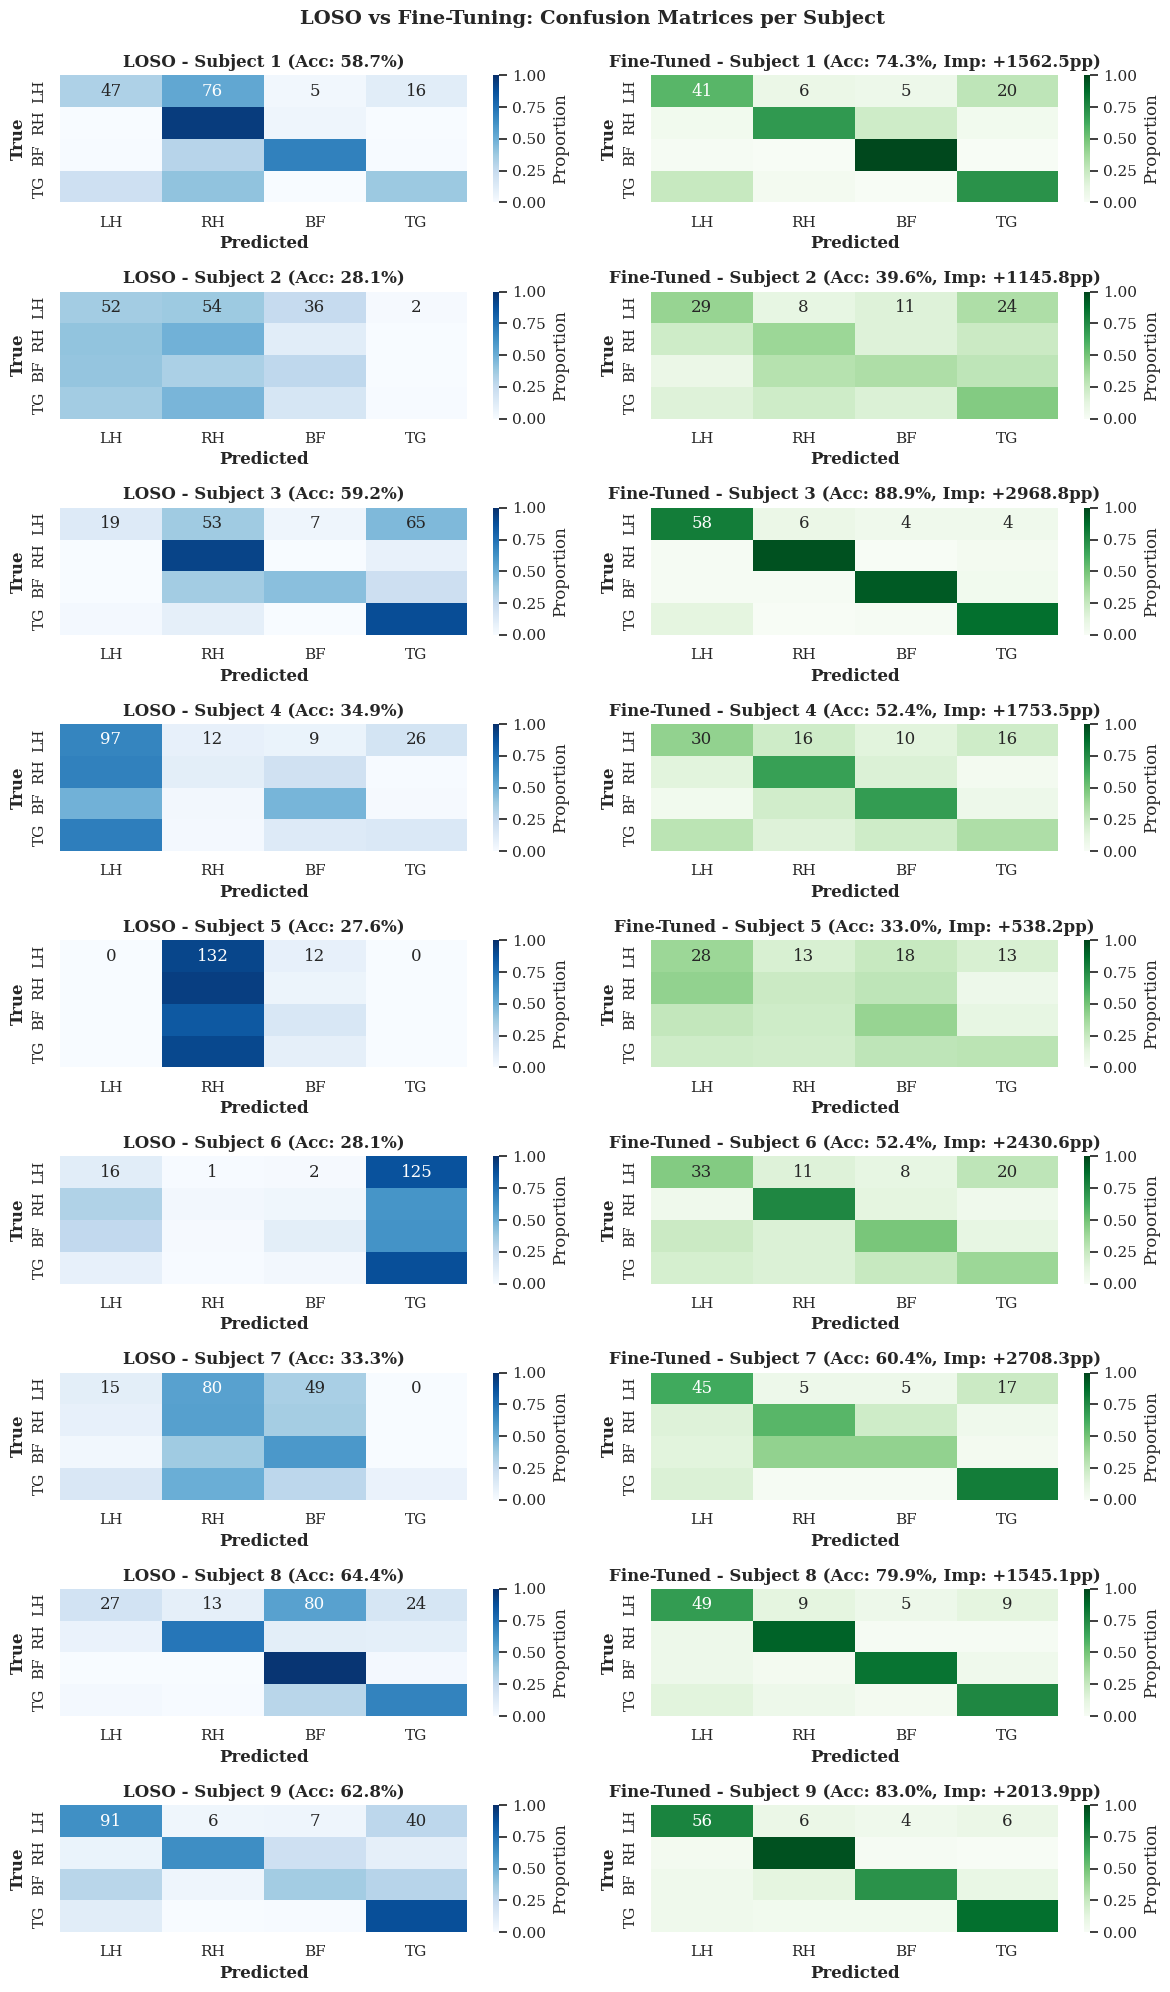

In [ ]:
# Confusion matrices comparison for each fold
fig, axes = plt.subplots(9, 2, figsize=(12, 20))

class_names = ['LH', 'RH', 'BF', 'TG']

for fold_idx in range(len(results['fold'])):
    # LOSO Confusion Matrix
    ax_loso = axes[fold_idx, 0]
    cm_loso = results['loso_cm'][fold_idx]
    cm_loso_normalized = cm_loso.astype('float') / cm_loso.sum(axis=1)[:, np.newaxis]

    sns.heatmap(cm_loso_normalized, annot=cm_loso, fmt='d', cmap='Blues', ax=ax_loso,
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Proportion'}, vmin=0, vmax=1)

    test_subject = int(results['test_subject'][fold_idx])
    loso_acc = results['loso_accuracy'][fold_idx]
    ax_loso.set_title(f'LOSO - Subject {test_subject} (Acc: {loso_acc*100:.1f}%)', fontweight='bold')
    ax_loso.set_ylabel('True', fontweight='bold')
    ax_loso.set_xlabel('Predicted', fontweight='bold')

    # Fine-Tuning Confusion Matrix
    ax_ftune = axes[fold_idx, 1]
    cm_ftune = results['finetune_cm'][fold_idx]
    cm_ftune_normalized = cm_ftune.astype('float') / cm_ftune.sum(axis=1)[:, np.newaxis]

    sns.heatmap(cm_ftune_normalized, annot=cm_ftune, fmt='d', cmap='Greens', ax=ax_ftune,
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Proportion'}, vmin=0, vmax=1)

    ftune_acc = results['finetune_accuracy'][fold_idx]
    improvement = results['improvement'][fold_idx]
    ax_ftune.set_title(f'Fine-Tuned - Subject {test_subject} (Acc: {ftune_acc*100:.1f}%, Imp: {improvement:+.1f}pp)',
                       fontweight='bold')
    ax_ftune.set_ylabel('True', fontweight='bold')
    ax_ftune.set_xlabel('Predicted', fontweight='bold')

plt.suptitle('LOSO vs Fine-Tuning: Confusion Matrices per Subject',
            fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('/Users/vigneshchaurasia/Desktop/Capstone Project/EEG Net/loso_finetuning_confusion_matrices.png',
           dpi=150, bbox_inches='tight')
print("✓ Figure saved: 'loso_finetuning_confusion_matrices.png'")
plt.show()